In [2]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import ccores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from utils import u_darrays as uda
from eod import msg_panAfrica
from utils import u_grid, u_interpolate as u_int
import glob
from utils import constants as cnst
import ipdb

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
msg_obj = xr.open_dataset(cnst.network_data+'data/COCOON/core_trend_testfiles/08/202308110830.nc')
roa_obj = xr.open_dataset(cnst.network_data+'data/COCOON/core_trend_testfiles/RoA/08/MSG320230811-S0830-E0845.nc')

In [4]:
#lls = [-21, 45, -33.2, 26]
#lls = [8, 42, -35, 0]
#lls = [-20, 42, -36, 25]\\
lls = [-25, 55, -38, 26]

In [5]:
tir = msg_obj['tir'].squeeze()
core = msg_obj['cores'].squeeze()
prcp = roa_obj['posterior_mean']

In [6]:
lpath = glob.glob('/home/ck/DIR/cornkle/data/nflics/geoloc/lat_lon_2268_2080.npz')[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system\n",
msg_latlon = np.load(lpath)
dlon = msg_latlon['lon']#[100:-100,100:-100]
dlat = msg_latlon['lat']#[100:-100,100:-100]

In [7]:
prcp = prcp.sel(longitude=slice(lls[0], lls[1]), latitude=slice(lls[2], lls[3]))

In [8]:
lonN, latN = prcp.longitude.values, prcp.latitude.values
inds, weights, shape = u_int.interpolation_weights(dlon[np.isfinite(dlon)], dlat[np.isfinite(dlat)], lonN, latN, irregular_1d=True)

In [9]:
data_test = tir.values
try:
    tir_on_roa = u_int.interpolate_data(data_test, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')

In [10]:
data_test = core.values
try:
    core_on_roa = u_int.interpolate_data(data_test, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')

In [11]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
 #   ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-23.0, 52.0)

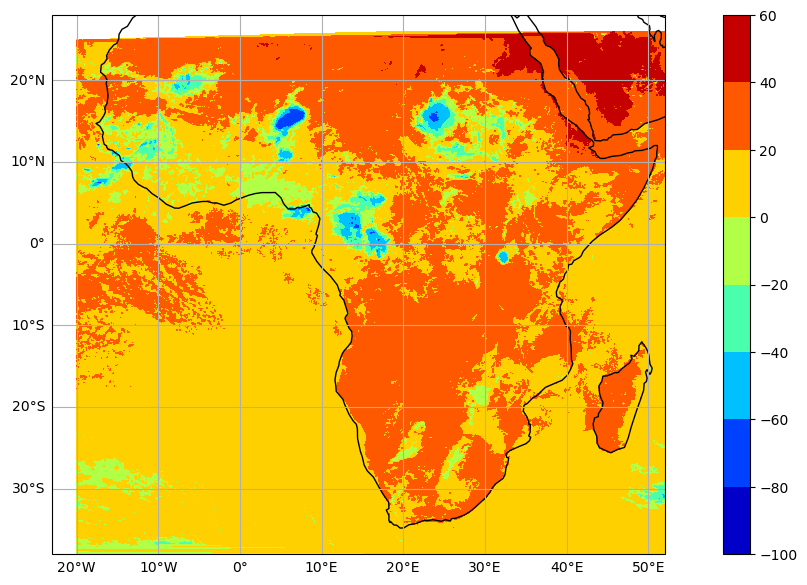

In [12]:
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
draw_map(ax, tir_on_roa, lonN, latN, cmap='jet')
ax.set_ylim(-38,28)
ax.set_xlim(-23,52)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(-23.0, 52.0)

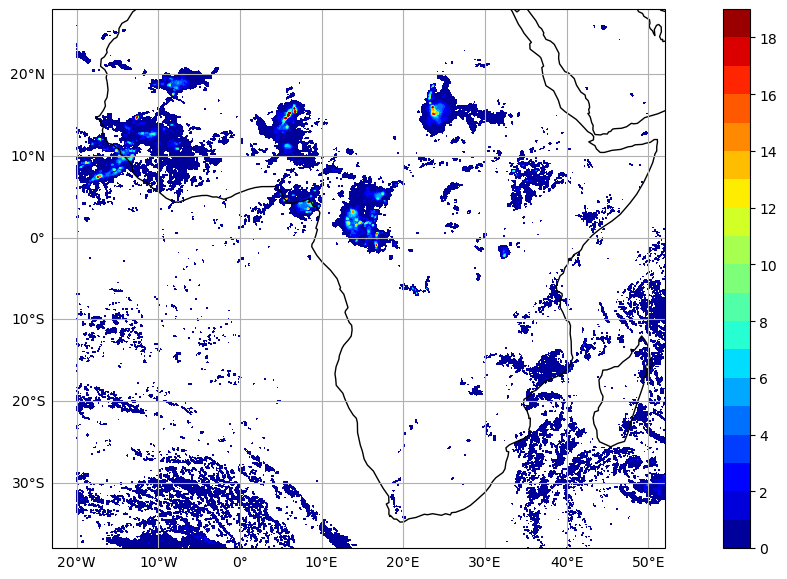

In [13]:
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
#draw_map(ax, ds['t'], ds.lon, ds.lat, levels=np.arange(-100,50), cmap='jet')
draw_map(ax, prcp, lonN, latN,levels=np.arange(0,20,1), cmap='jet')
ax.set_ylim(-38,28)
ax.set_xlim(-23,52)

In [14]:
box = [0,10,10,20]

In [15]:
wObj = cores.dataset('METEOSAT3K_veraLS')

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]


In [16]:
%%time
wObj.read_img(tir_on_roa, lonN, latN, edge_smoothing=False)
wObj.applyWavelet(normed='scale')
#current_nflics = wObj.scaleWeighting(wtype='nflics3k')
new_nflics = wObj.scaleWeighting(wtype='nflicsv2')

outmin -84.54570670344054 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
CPU times: user 22 s, sys: 1.59 s, total: 23.6 s
Wall time: 23.6 s


In [17]:
new_nflics

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

Text(0.5, 1.0, 'New calculated cores')

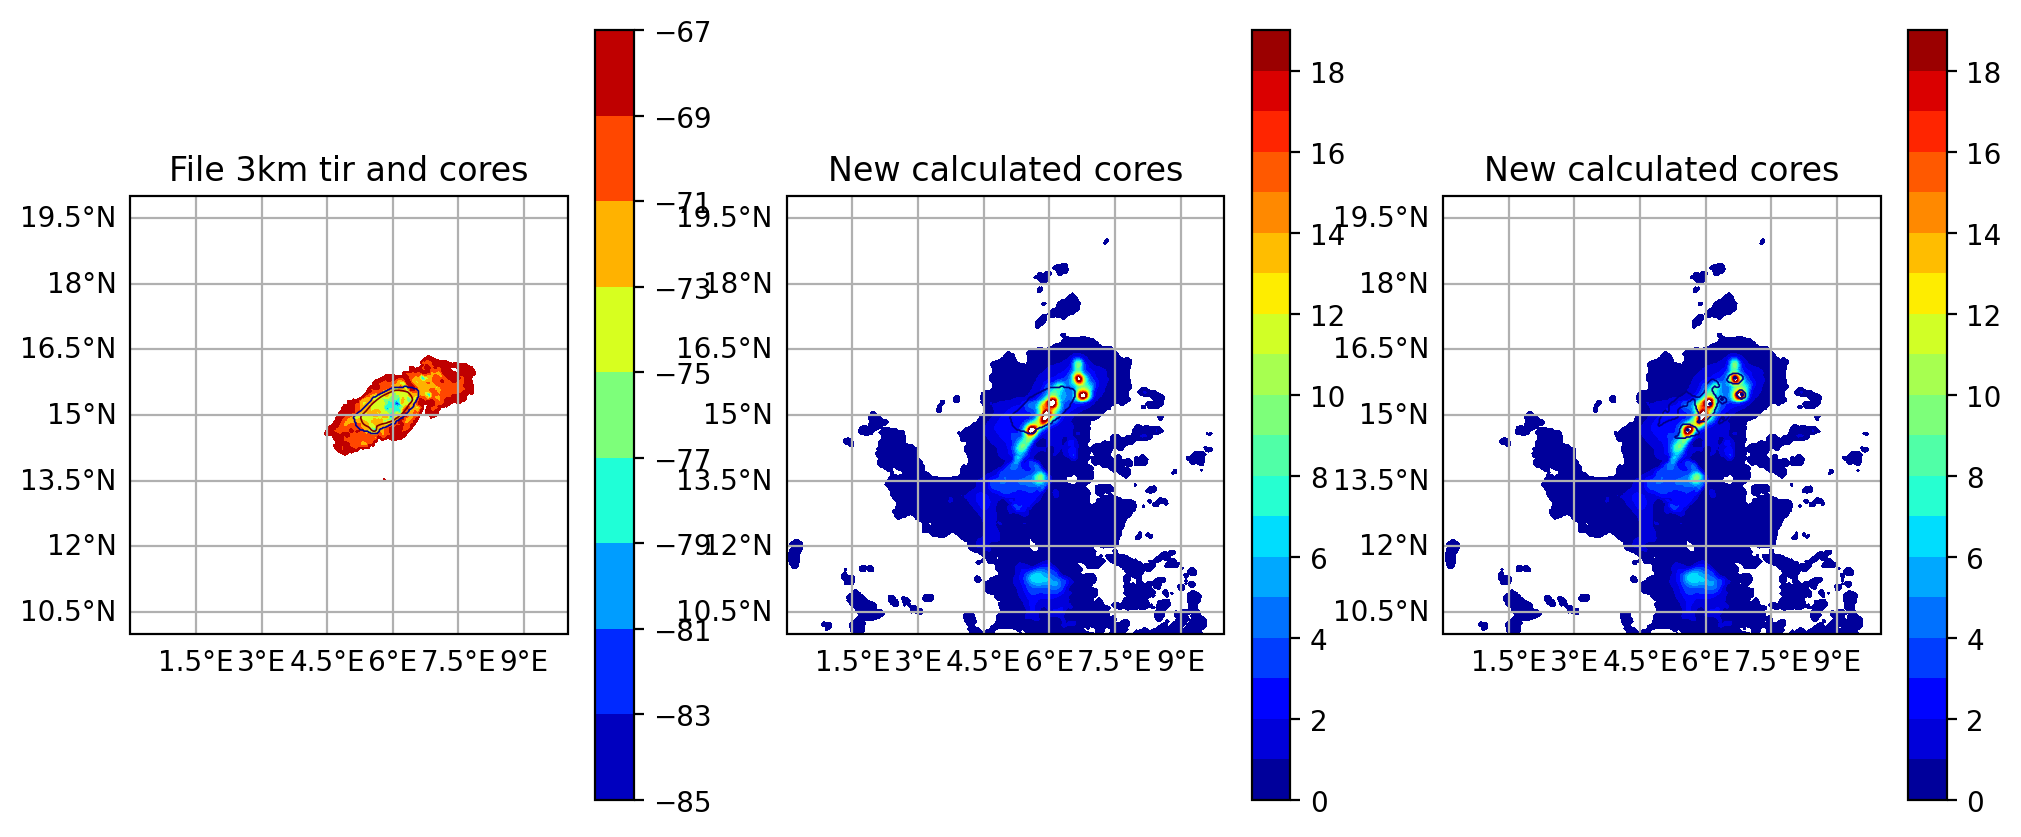

In [18]:
#box = [0,20,-5,10]
tmax = -65
tmin = -85
#perc = np.percentile(current_nflics[current_nflics>0],90)
f = plt.figure(figsize=(12,5), dpi=200)
ax = f.add_subplot(131, projection=ccrs.PlateCarree())
draw_map(ax, tir_on_roa, lonN, latN, cmap='jet', levels=np.arange(tmin,tmax,2))
ax.contour(lonN, latN,  core_on_roa, levels=[-1,1,100], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('File 3km tir and cores')

ax = f.add_subplot(132, projection=ccrs.PlateCarree())
#perc = np.percentile(current_nflics_std[current_nflics_std>0],90)
draw_map(ax,  prcp, lonN, latN, cmap='jet', levels=np.arange(0,20,1))
ax.contour(lonN, latN,  core_on_roa, levels=[-1,1,200], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New calculated cores') 

ax = f.add_subplot(133, projection=ccrs.PlateCarree())
#perc = np.percentile(current_nflics_std[current_nflics_std>0],90)
draw_map(ax, prcp, lonN, latN, cmap='jet', levels=np.arange(0,20,1))
ax.contour(lonN, latN,  new_nflics, levels=[-1,1,200], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New calculated cores')

In [12]:
def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [13]:
def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [14]:
def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [15]:
def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [16]:
def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [17]:
treached = []
tnames = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting'), (k3LS_grid['rain'], '3km LS, nflics weighting'), (k3LS_bigD['rain'], '3km LS, bigDomain weighting nfv2'), (k3['rain'], '3km small, 3kweighting'), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting'), (nflics['rain'], '5k, nflics'), (nflicsLS['rain'], '5k LS definition, nflics weighting'), (alls3k, '3k native rain'), (alls3k_reg, '3k regrid rain'), (alls5k, '5k rain')]:
    cc = calc_treshReached(dat[0],20)
    print(cc, dat[1])
    treached.append(cc)
    tnames.append(dat[1])

0.014928525107319799 3km LS, 3k weighting
0.011727434984764376 3km LS, nflics weighting
0.01478049987626825 3km LS, bigDomain weighting nfv2
0.013430530330018162 3km small, 3kweighting
0.012736360790138557 3km LS, 3k regridded, 3k weighting
0.008165688739871472 5k, nflics
0.009370938393553418 5k LS definition, nflics weighting
0.003458217018858159 3k native rain
0.0037427286383862686 3k regrid rain
0.0037623221709268276 5k rain


In [119]:
# import pickle as pkl
# for dat in [(k3LS, '3km LS, 3k weighting'), (k3LS_grid, '3km LS, nflics weighting'), (k3, '3km small, 3kweighting'), (k3LS_nflics, '3km LS, 3k regridded, 3k weighting'), (nflics, '5k, nflics'), (nflicsLS, '5k LS definition, nflics weighting'), (alls3k, '3k native rain'), (alls3k_reg, '3k regrid rain'), (alls5k, '5k rain')]:
#     pkl.dump(dat[0], open("/home/ck/DIR/cornkle/data/nflics/core_tests/"+dat[1]+"_southAfrica0-35S.p", "wb"))

In [656]:
# #save percentiles for filter or contour use
# for dat in [(k3LS, '3km LS, 3k weighting'), (k3LS_grid, '3km LS, nflics weighting'), (k3, '3km small, 3kweighting'), (k3LS_nflics, '3km LS, 3k regridded, 3k weighting'), (nflics, '5k, nflics'), (nflicsLS, '5k LS definition, nflics weighting')]:
#     perc = np.percentile(dat[0]['wav'], np.arange(50,100,5))
#     print(perc)
#     pkl.dump(perc, open("/home/ck/DIR/cornkle/data/nflics/core_tests/"+dat[1]+"_50-95_5step_percentiles.p", "wb"))

[145.68925912 154.6045336  164.40441867 175.49540259 188.14664331
 202.78138813 219.82352822 241.0763581  270.31755423 316.79180866]
[102.74613829 111.73680907 121.8930548  133.27193065 146.28414377
 161.59669112 180.14323807 203.33182855 233.80664645 283.38017364]
[281.94459958 297.05066143 313.73431319 332.4328058  353.72631993
 378.22639069 407.24986078 443.01907842 490.6509716  567.7480026 ]
[142.26155914 150.72534661 160.10214619 170.65636706 182.75239252
 196.54562398 212.96568346 233.51007126 262.24086651 308.59514012]
[ 39.83819145  44.06957418  48.95269823  54.68772905  61.54554385
  69.90648702  80.55575274  94.77742261 115.38045487 151.78379602]
[ 81.36445366  89.23964238  98.27792328 108.54026771 120.40546614
 134.19061669 150.97449914 173.15149292 204.38659597 255.72803878]


In [18]:
tcaught = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3LS_bigD['rain'], '3km LS, bigDomain weighting nfv2', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:

    cc = calc_treshMissed(dat[0],dat[2], 30)
    print(cc, dat[1], len(dat[0]))
    tcaught.append(cc)

0.4485278763833786 3km LS, 3k weighting 535083
0.7824180413447483 3km LS, nflics weighting 976002
0.41929421591146376 3km LS, bigDomain weighting nfv2 505125
0.5926080601378159 3km small, 3kweighting 684932
0.2449478697387051 3km LS, 3k regridded, 3k weighting 549372
0.22632711621233859 5k, nflics 286320
0.415351506456241 5k LS definition, nflics weighting 384700


In [20]:
tfrac = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3LS_bigD['rain'], '3km LS, bigDomain weighting nfv2', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:

    cc = calc_treshReached_vsObs(dat[0],dat[2], 25)
    print(cc, dat[1])
    tfrac.append(cc)

1.8357060174982255e-13 3km LS, 3k weighting
1.5980536640123232e-13 3km LS, nflics weighting
1.8257202301371226e-13 3km LS, bigDomain weighting nfv2
1.769665763868692e-13 3km small, 3kweighting
8.718169481432022e-14 3km LS, 3k regridded, 3k weighting
4.34516169002918e-13 5k, nflics
5.442244560415187e-13 5k LS definition, nflics weighting


In [21]:
for tr, tc, tn in zip(treached,tcaught,tnames):
    print(tr*tc, tn)

0.006695859663922098 3km LS, 3k weighting
0.009175756710777222 3km LS, nflics weighting
0.006197378106399383 3km LS, bigDomain weighting nfv2
0.007959040525494163 3km small, 3kweighting
0.0031197444437680104 3km LS, 3k regridded, 3k weighting
0.0018481167843826753 5k, nflics
0.003892233378671039 5k LS definition, nflics weighting


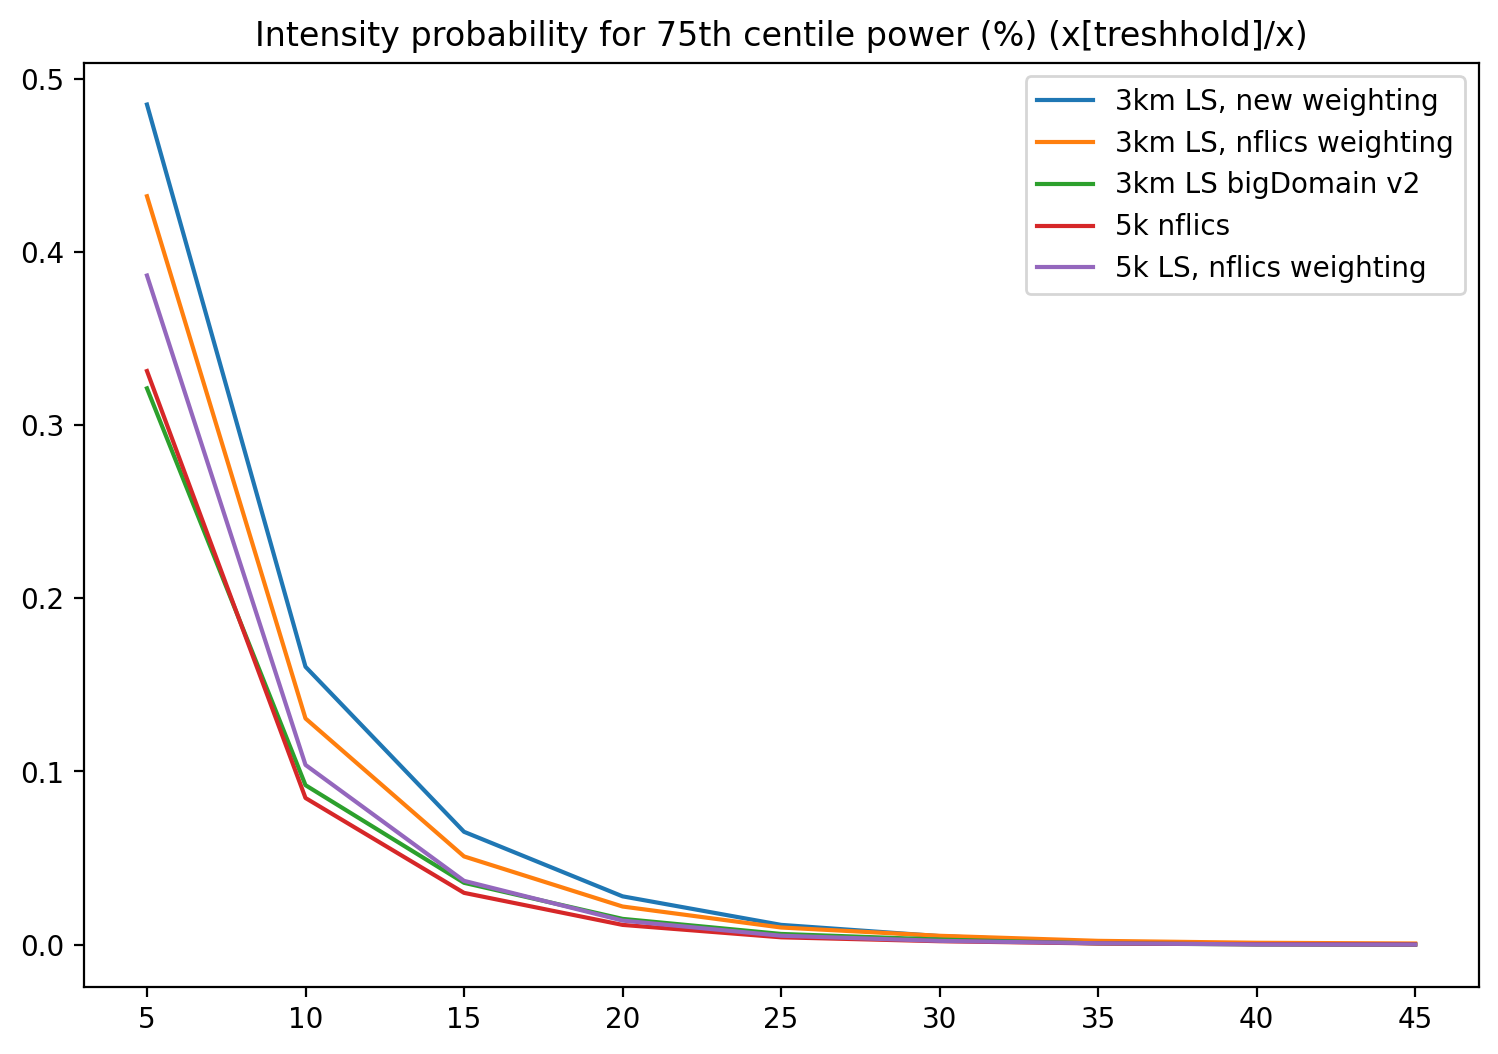

In [23]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'), (k3LS_bigD, '3km LS bigDomain v2'), (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['wav'], intens, 75)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

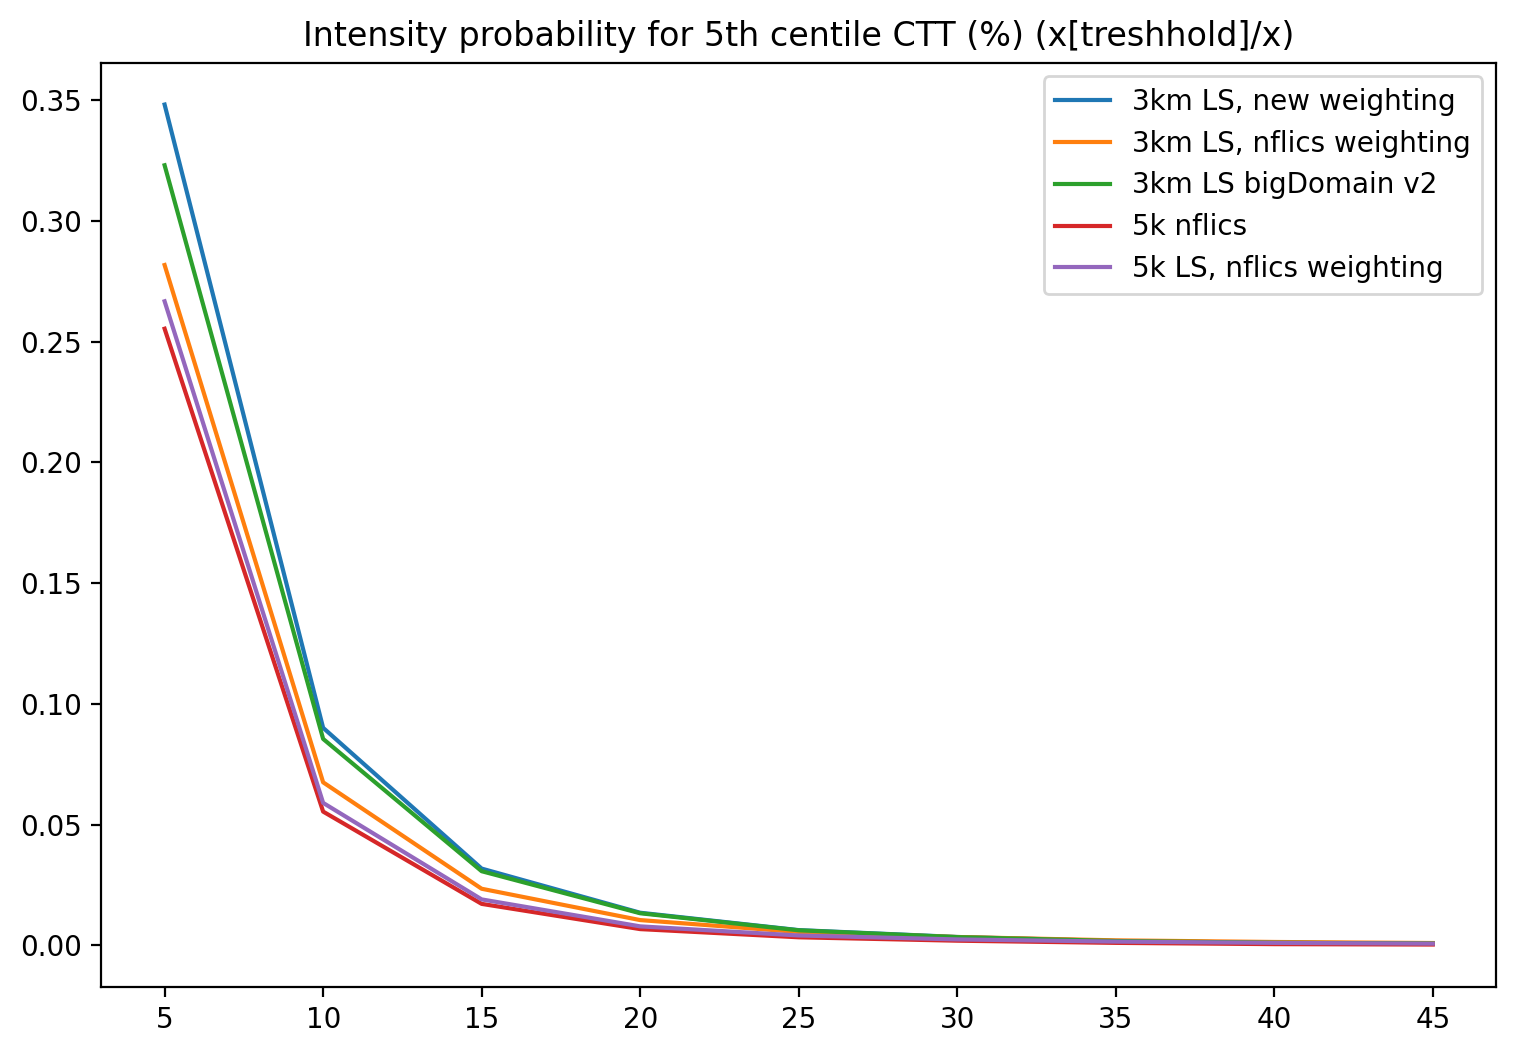

In [28]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'), (k3LS_bigD, '3km LS bigDomain v2'),  (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['t'], intens, 5)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 5th centile CTT (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_5pCTT.jpg')

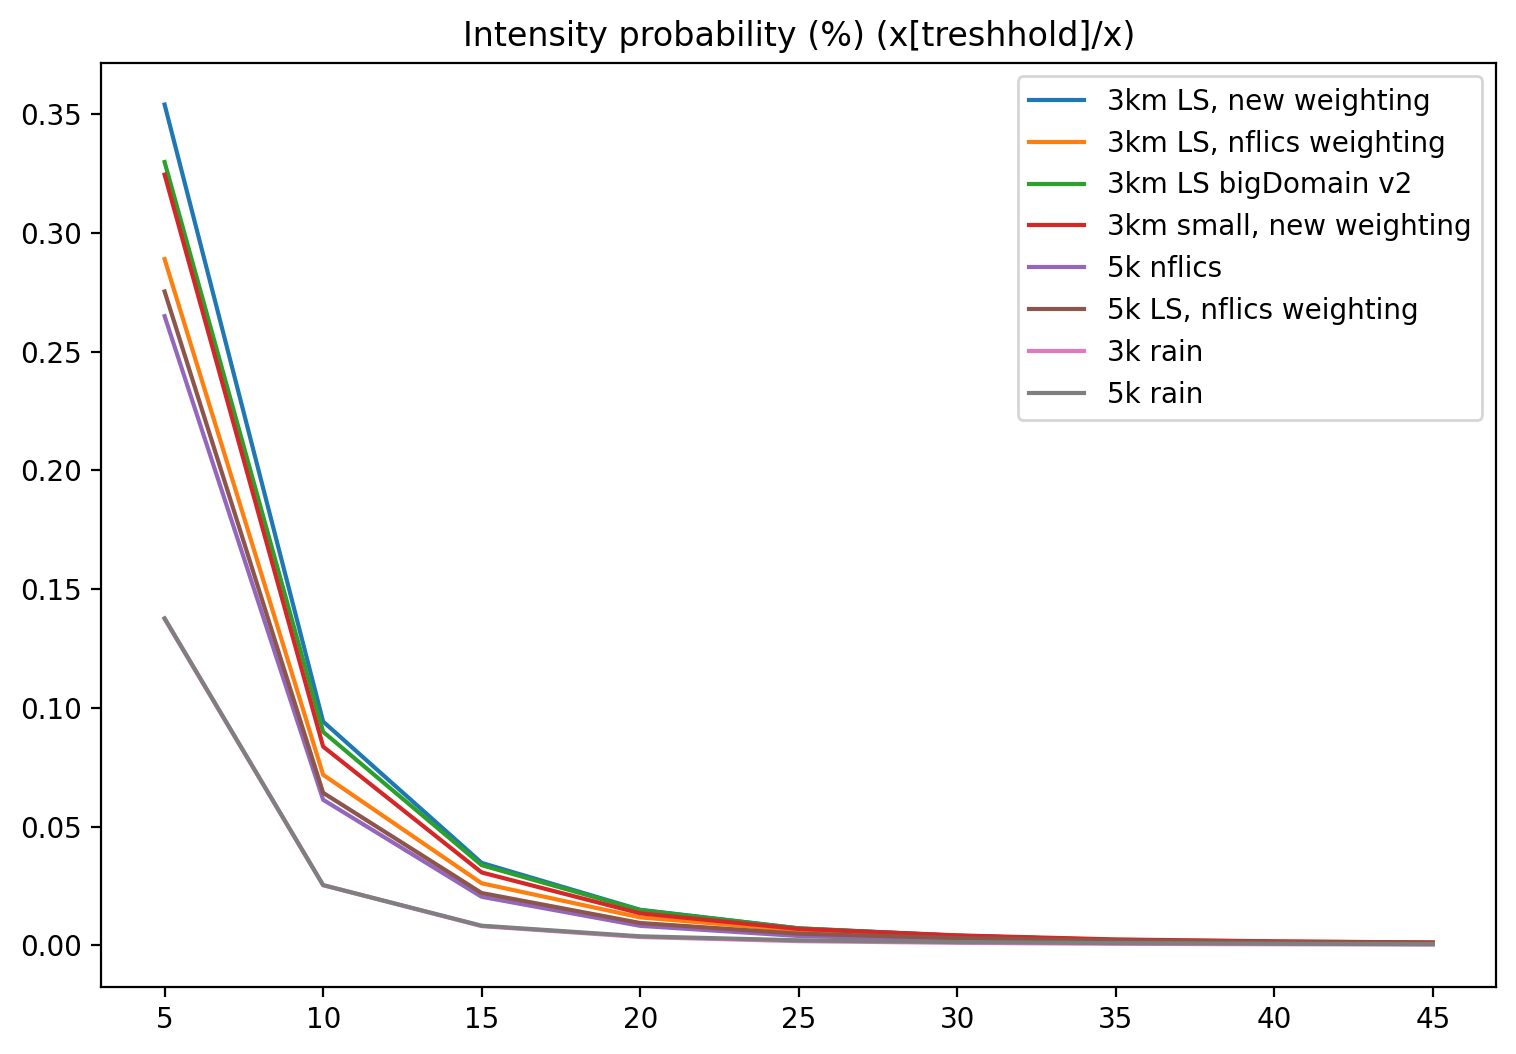

In [25]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS['rain'], '3km LS, new weighting'), (k3LS_grid['rain'], '3km LS, nflics weighting'), (k3LS_bigD['rain'], '3km LS bigDomain v2'), (k3['rain'], '3km small, new weighting'), (nflics['rain'], '5k nflics'), (nflicsLS['rain'], '5k LS, nflics weighting'), (alls3k, '3k rain'), (alls5k, '5k rain')]:
    treached = []
    for intens in range(5,50,5):
        cc = calc_treshReached(dat[0],intens)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability (%) (x[treshhold]/x)")
plt.legend()
 
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_95p_rainWav_southernAfricadomain.jpg')     

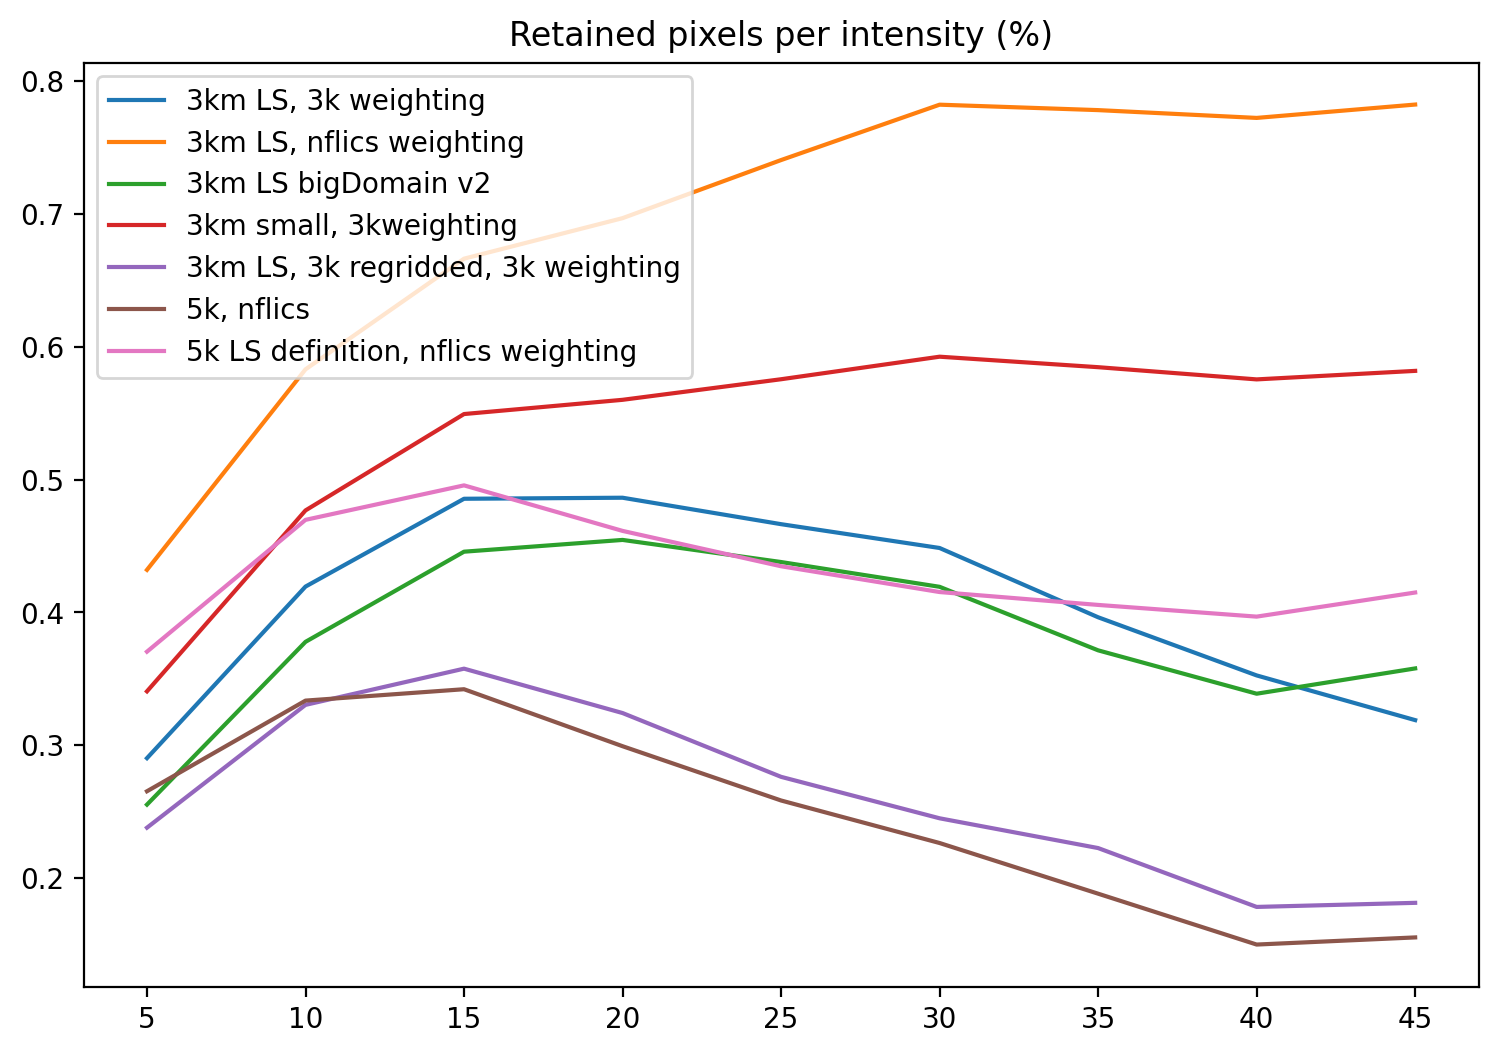

In [27]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3LS_bigD['rain'], '3km LS bigDomain v2', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:
    treached = []
    for intens in range(5,50,5):
        cc = calc_treshMissed(dat[0],dat[2],intens)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Retained pixels per intensity (%)")
plt.legend()
 
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'_missedCases_southernAfricaDomain.jpg')     